In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import fsolve
import csv
import sm_v2 as sm

def foam(rho):
    Av = 6.0221e23          # Avogadros number, particles/mole
                            # rho is in g/cm^3  -- this should be the number for the real foam density
    mole_foam = rho/13.5    # moles/cm^3
    n_foam = mole_foam*Av   # particles/cm^3
    return n_foam

def gas(P):
    Lo = 2.6868e19          # particles/cm^3
                            # P is in atm -- this should be based on the experimental pressure.
    n_H2 = 2.0*P*Lo         # H atoms/cm^3 at P[atm]
    n_D2 = 2.0*P*Lo         # D atoms/cm^3 at P[atm]
    n_T2 = 2.0*P*Lo         # T atoms/cm^3 at P[atm]
    return n_H2, n_D2, n_T2

def equations(v2, na, nb, za, zb):
    n1 = na
    n2 = na
    z1 = za
    z2 = zb
    #    z1,z2,T,n1,n2 = params
    zb1 = sm.zbar_n(n1,z1,T)
    zb2 = sm.zbar_n(n2,z2,T)
    return (v2*(n1*zb1/zb2+n2)-1.)

In [2]:
f_void = 0.5            # start with 50% void at fill time
r      = 0.05           # cm Initial radius of capusle, only used to get absolute numbers
P      = 30.0           # atm  Fill pressure
rho    = 0.1            # g/cm^3  Foam density at t=0
T  = 200               # in electron volts

In [3]:
def plasma(f_void, r, P, rho, T):

  # calculate the volume
  v_gas  = 4./3.*np.pi*r**3*f_void         # cm^3
  v_foam  = 4./3.*np.pi*r**3*(1.0-f_void)  # cm^3
  # get the foam and gas particle density
  n_foam = foam(rho)        # atoms/cm^3
  n_H2, n_D2, n_T2 = gas(P) # atoms/cm^3
  # now get the number of atoms in each the gas and the foam
  n_f = n_foam*v_foam
  n_g = n_D2*v_gas

  na = n_f
  vb = 0.4
  nb = na
  za = 6
  zb = 1

  v2 = fsolve(equations,vb, args=(na, nb, za, zb))
  zb1 = sm.zbar_n(na,za,T)
  zb2 = sm.zbar_n(nb,zb,T)
  v1 = v2[0]*zb1/zb2

  n1 = 1./v1
  n2 = 1./v2[0]
  nd = n2
  nc = n1

  ld = sm.lambdaI(T,n2,zb2)
  lc = sm.lambdaI(T,n1,zb1)
  gamd = sm.gamma(T,n2,zb2)
  gamc = sm.gamma(T,n1,zb1)

  ne = zb1*n1 + zb2*n2

  lel = sm.lambdaTF(T,ne)
  lec = sm.lambdaI(T,n1,zb1)
  led = sm.lambdaI(T,n2,zb2)
  lam = sm.lambdaTots(lel,lec,gamc,led,gamd)
  kappa = sm.kappa(T,ne)

  AMU = 1.6605e-24            # atomic mass unit
  md = 2*AMU
  mc = 12*AMU
  mu = sm.muij(mc,md)  

  erg_to_ev = 6.2451e11       #eV / (g cm^2 / s^2)

  lambdaTot = lam

  omega11 = sm.omegaij(1,1,zb1,zb2,T,lambdaTot,mu) #cm^3/g on all of these
  omega12 = sm.omegaij(1,2,zb1,zb2,T,lambdaTot,mu)
  omega13 = sm.omegaij(1,3,zb1,zb2,T,lambdaTot,mu)
  omega22 = sm.omegaij(2,2,zb1,zb2,T,lambdaTot,mu)
  omegadd = sm.omegaij(2,2,zb2,zb2,T,lambdaTot,md)
  omegacc = sm.omegaij(2,2,zb1,zb1,T,lambdaTot,mc)

  etad = 5.*T/8./omegadd/erg_to_ev           #g / (cm s)
  etac = 5.*T/8./omegacc/erg_to_ev
  Md = md/(md+mc)                            #unitless
  Mc = mc/(md+mc)                
  xc = nc/(nc+nd)               
  xd = nd/(nc+nd) 
  A = omega22/5./omega11                     #unitless
  B = (5*omega12 - omega13)/5./omega11       #unitness
  C = 2.*omega12/5./omega11 - 1.             #unitless
  ep = T/(8.*Md*Mc*omega11)/erg_to_ev        #g / (cm s) 
  Pd = Md*ep/etad                            #unitless
  Pc = Mc*ep/etac                            #unitless
  Pdc = 3*(Md-Mc)**2 + 4.*Md*Mc*A            #unitless
  Qc = Pc*(6*Md*Md+5*Mc*Mc-4*B*Mc*Mc+8*Mc*Md*A)   #unitless
  Qd = Pd*(6*Mc*Mc+5*Md*Md-4*B*Md*Md+8*Mc*Md*A)   #unitless
  Qcd_p = (15*ep*(Pc+Pd+(11-4*B-8*A)*Mc*Md))/(2*(mc+md)) # 1/(cm s)
  Qcd = 2*Pc*Pd+3*(Mc-Md)**2*(5-4*B)+4*Mc*Md*A*(11-4*B)  #unitless  --- TYPO
  Rc = 2./3.+Mc/Md*A                         #unitless
  Rd = 2./3.+Md/Mc*A                         #unitless 
  Rcd = 4*A/(3*Mc*Md*ep) + ep/(2*etad*etac)  #(cm s)/g
  Rcd_p = 4./3.+ep/(2*etac)+ep/(2*etad)-2*A  #unitless
  Sc = Mc*Pc-Md*(3*(Md-Mc)+4*Mc*A)           #unitless
  Sd = Md*Pd-Mc*(3*(Mc-Md)+4*Md*A)           #unitless
  Kc = 75*T/(32*mc*omegacc)/erg_to_ev #1/(s cm) 
  Kd = 75*T/(32*md*omegadd)/erg_to_ev

  Dcd = 3*T/(16*(nd+nc)*mu*omega11)/erg_to_ev     #cm^2/s
  eta = (xc*xc*Rc+xd*xd*Rd+xc*xd*Rcd_p)/(xc*xc*Rc/etac+xd*xd*Rd/etad+xc*xd*Rcd) #g / (cm s)
  Ktot = (xc*xc*Qc*Kc+xd*xd*Qd*Kd+xc*xd*Qcd_p)/(xc*xc*Qc+xd*xd*Qd+xc*xd*Qcd) # 1 / (cm s)
  KT = (5*xc*xd*C*(xc*Sc-xd*Sd))/(xc*xc*Qc+xd*xd*Qd+xc*xd*Qcd)               #unitless
  return (zb1,zb2,n1,n2,ne,gamc,gamd,lel,lc,ld,lam,kappa,Dcd,eta,Ktot,KT,etad,etac,Kc,Kd)

In [4]:
zb1,zb2,n1,n2,ne,gamc,gamd,lel,lc,ld,lam,kappa,Dcd,eta,Ktot,KT,etad,etac,Kc,Kd = plasma(f_void, r, P, rho, T)

print("Temperature T[eV]= ",T, "z_carbon= ", zb1,",z_d= ",zb2)
print("number denstiy [1/cm^3] of Carbon and D, n_c= ",n1,",n_d= ", n2)
print("number denstiy of electrons [1/cm^3], n_e= ",ne)
print("Coupling Constant $\gamma$ of Carbon and D, G_c= ",gamc,",G_d= ", gamd)
print("")
print("elecron lambda[cm]= ",lel)
print("carbon lambda[cm]= ",lc," deuterium lambda[cm]= ", ld)
print("Total lambda[cm]= ", lam," kappa= ",kappa)
print("")
print("Diffusion[cm^2/s] = ",Dcd)
print("viscocity[g/cm s] = ", eta)
print("Conduction[1/cm s] = ", Ktot)
print("K_T = ", KT)
print("")
print("eta_dd[g/cm s] = ",etad)
print("eta_cc[g/cm s] = ",etac)
print("Kc[1/cm s] = ", Kc)
print("Kd[1/cm s] = ", Kd)

Temperature T[eV]=  200 z_carbon=  5.96061453177 ,z_d=  0.999480782195
number denstiy [1/cm^3] of Carbon and D, n_c=  1.36366272936e+18 ,n_d=  8.13249041487e+18
number denstiy of electrons [1/cm^3], n_e=  1.62565357621e+19
Coupling Constant $\gamma$ of Carbon and D, G_c=  0.0457273109203 ,G_d=  0.00233156761214

elecron lambda[cm]=  2.60745528446e-06
carbon lambda[cm]=  1.51038042341e-06  deuterium lambda[cm]=  3.68845630137e-06
Total lambda[cm]=  1.28506080268e-06  kappa=  0.0939170104162

Diffusion[cm^2/s] =  3410.84231062
viscocity[g/cm s] =  0.429705657497
Conduction[1/cm s] =  4.05203019618e+23
K_T =  -0.786783971194

eta_dd[g/cm s] =  4.1103745817
eta_cc[g/cm s] =  0.0149159744158
Kc[1/cm s] =  2.80713158985e+21
Kd[1/cm s] =  4.64134437862e+24


In [18]:
size = 10
T_range  = np.linspace(1.0,100.0,size)
rho_range = np.linspace(0.001,0.2,size)
eta_tab = []
dif_tab = []
K_tab   = []
zbarC_tab = []
zbarD_tab = []
for i in range(size): # T is outer 
    T = T_range[i]
    eta_tabR = []
    dif_tabR = []
    K_tabR   = []
    zbarC_tabR = []
    zbarD_tabR = []
    for j in range(size): # rho is inner
        rho = rho_range[j]
        zb1,zb2,n1,n2,ne,gamc,gamd,lel,lc,ld,lam,kappa,Dcd,eta,Ktot,KT,etad,etac,Kc,Kd = plasma(f_void, r, P, rho, T)
        eta_tabR.append(eta)
        dif_tabR.append(Dcd)
        K_tabR.append(KT)
        zbarC_tabR.append(zb1)
        zbarD_tabR.append(zb2)
    eta_tab.append(eta_tabR)
    dif_tab.append(dif_tabR)
    K_tab.append(K_tabR)
    zbarC_tab.append(zbarC_tabR)
    zbarD_tab.append(zbarD_tabR)

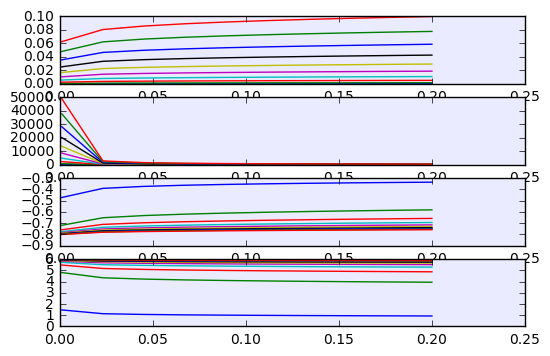

In [19]:
ax = plt.subplot('411', axisbg='#EBEBFF')
ax.plot(rho_range,eta_tab[0])
ax.plot(rho_range,eta_tab[1])
ax.plot(rho_range,eta_tab[2])
ax.plot(rho_range,eta_tab[3])
ax.plot(rho_range,eta_tab[4])
ax.plot(rho_range,eta_tab[5])
ax.plot(rho_range,eta_tab[6])
ax.plot(rho_range,eta_tab[7])
ax.plot(rho_range,eta_tab[8])
ax.plot(rho_range,eta_tab[9])
ax1 = plt.subplot('412', axisbg='#EBEBFF')
ax1.plot(rho_range,dif_tab[0])
ax1.plot(rho_range,dif_tab[1])
ax1.plot(rho_range,dif_tab[2])
ax1.plot(rho_range,dif_tab[3])
ax1.plot(rho_range,dif_tab[4])
ax1.plot(rho_range,dif_tab[5])
ax1.plot(rho_range,dif_tab[6])
ax1.plot(rho_range,dif_tab[7])
ax1.plot(rho_range,dif_tab[8])
ax1.plot(rho_range,dif_tab[9])
ax2 = plt.subplot('413', axisbg='#EBEBFF')
ax2.plot(rho_range,K_tab[0])
ax2.plot(rho_range,K_tab[1])
ax2.plot(rho_range,K_tab[2])
ax2.plot(rho_range,K_tab[3])
ax2.plot(rho_range,K_tab[4])
ax2.plot(rho_range,K_tab[5])
ax2.plot(rho_range,K_tab[6])
ax2.plot(rho_range,K_tab[7])
ax2.plot(rho_range,K_tab[8])
ax2.plot(rho_range,K_tab[9])
ax3 = plt.subplot('414', axisbg='#EBEBFF')
ax3.plot(rho_range,zbarC_tab[0])
ax3.plot(rho_range,zbarC_tab[1])
ax3.plot(rho_range,zbarC_tab[2])
ax3.plot(rho_range,zbarC_tab[3])
ax3.plot(rho_range,zbarC_tab[4])
ax3.plot(rho_range,zbarC_tab[5])
ax3.plot(rho_range,zbarC_tab[6])
ax3.plot(rho_range,zbarC_tab[7])
ax3.plot(rho_range,zbarC_tab[8])
ax3.plot(rho_range,zbarC_tab[9])
plt.show()